# train data vectorizing & labeling

In [1]:
# train data path
import os
import numpy as np
from numpy import array
TRAIN_DIR = 'D:/MNIST/trainingSet/'
train_folder_list = array(os.listdir(TRAIN_DIR))
train_folder_list

array(['0_zero', '1_one', '2_two', '3_three', '4_four', '5_five', '6_six',
       '7_seven', '8_eight', '9_nine'], dtype='<U7')

In [2]:
# path 라벨링
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()  # LabelEncoder Class 호출
integer_encoded = label_encoder.fit_transform(train_folder_list)
integer_encoded

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [3]:
# 라벨링 벡터화
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(categories='auto', sparse=False) 
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print('integer_encoded:\n', integer_encoded)
print('onehot_encoded:\n', onehot_encoded)

integer_encoded:
 [[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]
onehot_encoded:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [4]:
type(onehot_encoded)

numpy.ndarray

In [5]:
# 이미지를 불러와서 흑백으로 벡터화 및 라벨링
import cv2
train_input = []
train_label = []
for index in range(len(train_folder_list)):
    path = os.path.join(TRAIN_DIR, train_folder_list[index])
    path = path + '/'
    img_list = os.listdir(path)
    for img in img_list:
        img_path = os.path.join(path, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # cv2.imread: paht경로에 있는 이미지를 흑백으로 불러옴
        train_input.append([np.array(img)])
        train_label.append([np.array(onehot_encoded[index])])

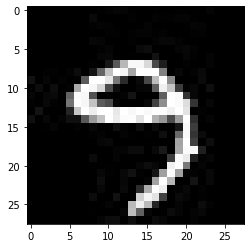

In [6]:
# 마지막 이미지 시각화
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(img, cmap='gray')

In [7]:
len(train_input) #train_input은 [[img],[img],...,[img]] 이런 형태

42000

### list형태를 np.array형태(42000,784)로 reshape

In [8]:
train_input = np.reshape(train_input, (-1, 784))
# 이때 -1은 정확한 개수를 모를때 사용. -1대신 42000 넣어도 상관x
train_label = np.reshape(train_label, (-1, 10))
train_input = np.array(train_input).astype(np.float32)
train_label = np.array(train_label).astype(np.float32)

#데이터 섞기
tmp = [[x,y] for x, y in zip(train_input, train_label)]
np.random.shuffle(tmp)
train_input = np.array([n[0] for n in tmp])
train_label = np.array([n[1] for n in tmp])

np.save("train_data.npy", train_input)
np.save("train_label.npy", train_label)
print('train_input.shape: ', train_input.shape)
print('train_label.shape: ', train_label.shape)

train_input.shape:  (42000, 784)
train_label.shape:  (42000, 10)


# test data vectorizing & labeling

In [9]:
TEST_DIR = 'D:/MNIST/testSet/'
test_folder_list = array(os.listdir(TEST_DIR))
 
test_input = []
test_label = []
 
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(test_folder_list)
 
onehot_encoder = OneHotEncoder(categories='auto', sparse=False) 
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
 
for index in range(len(test_folder_list)):
    path = os.path.join(TEST_DIR, test_folder_list[index])
    path = path + '/'
    img_list = os.listdir(path)
    for img in img_list:
        img_path = os.path.join(path, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        test_input.append([np.array(img)])
        test_label.append([np.array(onehot_encoded[index])])
 
test_input = np.reshape(test_input, (-1, 784))
test_label = np.reshape(test_label, (-1, 10))
test_input = np.array(test_input).astype(np.float32)
test_label = np.array(test_label).astype(np.float32)

#데이터 섞기
tmp = [[x,y] for x, y in zip(test_input, test_label)]
np.random.shuffle(tmp)
test_input = np.array([n[0] for n in tmp])
test_label = np.array([n[1] for n in tmp])

np.save("test_input.npy",test_input)
np.save("test_label.npy",test_label)

# Autoencoder를 이용한 MNIST 데이터 재구축

In [18]:
import tensorflow as tf

# 학습에 필요한 설정값들을 정의
learning_rate = 0.02
training_epochs = 50    # 반복횟수
batch_size = 256        # 배치개수
display_step = 5        # 손실함수 출력 주기
examples_to_show = 10   # 보여줄 MNIST Reconstruction 이미지 개수
input_size = 784        # 28*28
hidden1_size = 256      # 16*16
hidden2_size = 128

# 입력을 받기 위한 플레이스홀더를 정의
# Autoencoder는 Unsupervised Learning이므로 타겟 레이블(label) y가 필요하지 않음
x = tf.placeholder(tf.float32, shape=[None, input_size])
#y = tf.placeholder(tf.float32, shape=[None, 10]) 

In [19]:
# Autoencoder 구조를 정의
def build_autoencoder(x):
    # 인코딩(Encoding) - 784 -> 256 -> 128
    W1 = tf.Variable(tf.random_normal(shape=[input_size, hidden1_size]))
    b1 = tf.Variable(tf.random_normal(shape=[hidden1_size]))
    H1_output = tf.nn.sigmoid(tf.matmul(x,W1) + b1)
    W2 = tf.Variable(tf.random_normal(shape=[hidden1_size, hidden2_size]))
    b2 = tf.Variable(tf.random_normal(shape=[hidden2_size]))
    H2_output = tf.nn.sigmoid(tf.matmul(H1_output,W2) + b2)
    # 디코딩(Decoding) 128 -> 256 -> 784
    W3 = tf.Variable(tf.random_normal(shape=[hidden2_size, hidden1_size]))
    b3 = tf.Variable(tf.random_normal(shape=[hidden1_size]))
    H3_output = tf.nn.sigmoid(tf.matmul(H2_output,W3) + b3)
    W4 = tf.Variable(tf.random_normal(shape=[hidden1_size, input_size]))
    b4 = tf.Variable(tf.random_normal(shape=[input_size]))
    reconstructed_x = tf.nn.sigmoid(tf.matmul(H1_output,W4) + b4)

    return reconstructed_x

In [20]:
# Autoencoder를 선언
y_pred = build_autoencoder(x)
# 타겟데이터는 인풋데이터와 같음
y_true = x

# 손실함수와 옵티마이저를 정의
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))   # MSE 손실함수
train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

In [21]:
# 세션을 열고 변수들에 초기값을 할당
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 전체 배치 개수를 불러옴
total_batch = int(len(train_input)/batch_size) # total_batch = int(42000/300) = 140

# 지정된 횟수만큼 최적화를 수행
for epoch in range(training_epochs): # training_epochs = 30000
    average_loss = 0
    # 모든 배치들에 대해서 최적화를 수행
    for i in range(total_batch):
        start = ((i+1) * batch_size) - batch_size
        # 데이터를 분할하기 위해 start라는 변수를 선언
        # i는 0에서 164까지 변함
        # i = 0일 때 start에 저장되는 값은 (0+1)*256)-256이므로 0이 저장
        end = ((i+1) * batch_size)
        # 데이터를 분할하기 위해 end라는 변수를 선언
        # i = 0일 때 emd에 저장되는 값은 (0+1)*256)이므로 256이 저장
        batch_xs = train_input[start:end] / 255
        # batch_xs : train 데이터의 input을 저장하는 변수
        # train_input[start:end]는 train_input[0:256]과 같음
        # 즉, train_input에서 0~256에 위치하는 데이터를 불러서 batch_xs에 저장
        feed_dict = {x: batch_xs}
        # feed dictionary를 선언
        # x는 input data에 대한 placeholder
        _, current_loss = sess.run([train_step, loss], feed_dict=feed_dict)
        # 옵티마이저를 실행해서 파라마터들을 업데이트
        average_loss += current_loss / total_batch
        # 평균 손실을 측정
    # 지정된 epoch마다 학습결과를 출력
    if epoch % display_step == 0:
        print("반복(Epoch): %d, 손실 함수(Loss): %f" % ((epoch+display_step), average_loss))

반복(Epoch): 5, 손실 함수(Loss): 0.418762
반복(Epoch): 10, 손실 함수(Loss): 0.055517
반복(Epoch): 15, 손실 함수(Loss): 0.042427
반복(Epoch): 20, 손실 함수(Loss): 0.035901
반복(Epoch): 25, 손실 함수(Loss): 0.033543
반복(Epoch): 30, 손실 함수(Loss): 0.031739
반복(Epoch): 35, 손실 함수(Loss): 0.031344
반복(Epoch): 40, 손실 함수(Loss): 0.029855
반복(Epoch): 45, 손실 함수(Loss): 0.028956
반복(Epoch): 50, 손실 함수(Loss): 0.027216


C:\Users\tldud\.conda\envs\tldud\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


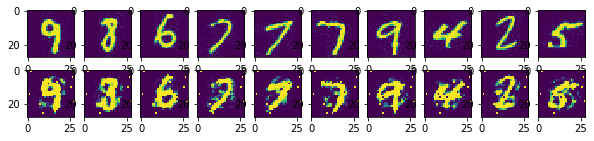

In [22]:
import matplotlib.pyplot as plt

# 테스트 데이터로 Reconstruction을 수행
# examples_to_show = 10
reconstructed_result = sess.run(y_pred, feed_dict={x:test_input[:examples_to_show]})
# 원본 MNIST 데이터와 Reconstruction 결과를 비교
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(test_input[i], (28, 28)))
    a[1][i].imshow(np.reshape(reconstructed_result[i], (28, 28)))
f.savefig('reconstructed_mnist_image.png')  # reconstruction 결과를 png로 저장
f.show()
#plt.draw()
#plt.waitforbuttonpress()